# *Mind the Portability* "Portability No-MDM" Hyperparameter Tuning Reproduction

This notebook replicated the Hyperparameter Tuning process used in the paper "Mind the Portability".\
In particular, the case "Portability No-MDM" is considered: the model is trained with traces from Device_A, validated with traces from Device_B and tested against Device_C.

The fixed parameters (e.g. number of epochs, batch_size, ...) and the network structure are taken from the paper.\
Also the number of experiment for GE computation is the one used in the paper.

In [1]:
# Basic
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop

# Custom
import sys
sys.path.insert(0, '../src/utils')
from data_loader import DataLoader
import aes
import constants
import results


# Suppress TensorFlow messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # 1 for INFO, 2 for INFO & WARNINGs, 3 for INFO & WARNINGs & ERRORs

In [2]:
# "Mind the Portability" fixed papameters
EPOCHS = 50
GE_EXPS = 100
BATCH_SIZE = 256
POSSIBLE_LAYERS = [1, 2, 3, 4]
POSSIBLE_NEURONS = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
TARGET = 'SBOX_OUT'

# Custom parameters
BYTE_IDX = 5
N_TOT_TRACES = 50000
TRAIN_CONFIG = ['D1-K5']
VAL_CONFIG = ['D2-K8']
TEST_CONFIG = ['D3-K0']

MTP_RES_ROOT = '/prj/side_channel/Pinata/results/MTP_Reproduction/portability_no_mdm'
MTP_GE_PATH = MTP_RES_ROOT + f'/ge.npy'
MTP_GE_PLOT_PATH = MTP_RES_ROOT + f'/ge.png'

In [3]:
def build_model(layers, neurons):

    # The total amount of layers of the network is (layers + 1)

    model = Sequential()

    model.add(
        Dense(neurons, activation='relu', input_shape=(constants.TRACE_LEN,))
    )

    for _ in range(layers - 1):
        model.add(
            Dense(neurons, activation='relu')
        )

    model.add(
        Dense(256, activation='softmax')
    )

    model.compile(
        optimizer=RMSprop(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [4]:
def hp_tuning(x_train, y_train, x_val, y_val):
    
    """
    Reproduces "Mind the Portability" hyperparameter tuning.
    
    Parameters:
        - x_train, x_val (np.ndarray):
            Train and validation samples.
        - y_train, y_val (np.ndarray):
            Train and validation labels.
    """

    res = []
    for layers in tqdm(POSSIBLE_LAYERS, desc='HP Tuning: '):
        for neurons in POSSIBLE_NEURONS:

            model = build_model(layers, neurons)
            model.fit(
                x_train, 
                y_train, 
                validation_data=(x_val, y_val),
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                verbose=0
            )
            _, val_acc = model.evaluate(
                x_val, 
                y_val, 
                batch_size=BATCH_SIZE, 
                verbose=0
            )

            res.append((val_acc, layers, neurons))
    
    res.sort(key=lambda x: x[0], reverse=True)
    
    return res[0]

In [5]:
def plot_ge(ge, output_path):

    """
    Plots the provided GE vector.
    
    Parameters:
        - ge (np.array):
            GE vector to plot.
        - output_path (str):
            Absolute path to the PNG file containing the plot.
    """
    
    ge = ge[:15]
    
    # Plot GE
    f, ax = plt.subplots(figsize=(15,8))
    
    ax.plot(ge, marker='o', color='b')
        
    ax.set_title(f'Byte: {BYTE_IDX}  |  Train: {TRAIN_CONFIG[0]}  |  Val: {VAL_CONFIG[0]}  |  Test: {TEST_CONFIG[0]}')
    ax.set_xticks(range(len(ge)), labels=range(1, len(ge)+1)) 
    ax.set_xlabel('Number of traces')
    ax.set_ylabel('GE')
    ax.grid()

    f.savefig(
        output_path, 
        bbox_inches='tight', 
        dpi=600
    )
    
    plt.show()
    
    plt.close(f)

In [6]:
train_dl = DataLoader(
    TRAIN_CONFIG,
    n_tot_traces=45000,
    target=TARGET,
    byte_idx=BYTE_IDX
)
x_train, y_train, _, _ = train_dl.load()

val_dl = DataLoader(
    VAL_CONFIG,
    n_tot_traces=5000,
    target=TARGET,
    byte_idx=BYTE_IDX
)
x_val, y_val, _, _ = val_dl.load()

test_dl = DataLoader(
    TEST_CONFIG,
    n_tot_traces=5000,
    target=TARGET,
    byte_idx=BYTE_IDX
)
x_test, y_test, pbs_test, tkb_test = test_dl.load()

In [7]:
val_acc, layers, neurons = hp_tuning(x_train, y_train, x_val, y_val)

print()

print(f'Selected Layers:  {layers}')
print(f'Selected Neurons: {neurons}')
print(f'Best Val Acc:     {val_acc*100:.2f}%')

HP Tuning: 100%|██████████| 4/4 [12:31<00:00, 187.91s/it]


Selected Layers:  3
Selected Neurons: 100
Best Val Acc:     4.38%


In [8]:
final_model = build_model(layers, neurons)
final_model.fit(
    x_train, 
    y_train, 
    validation_data=(x_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=0
)

In [9]:
preds = final_model.predict(x_test)

ge = results.ge(
    preds=preds, 
    pltxt_bytes=pbs_test, 
    true_key_byte=tkb_test, 
    n_exp=GE_EXPS, 
    target=TARGET,
    n_traces=100 # Default: 500
)

np.save(MTP_GE_PATH, ge)

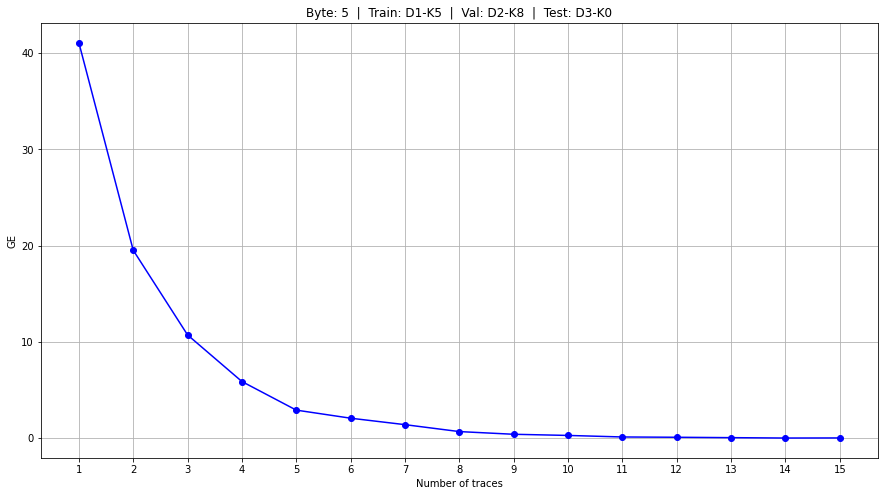

In [10]:
plot_ge(ge, MTP_GE_PLOT_PATH)